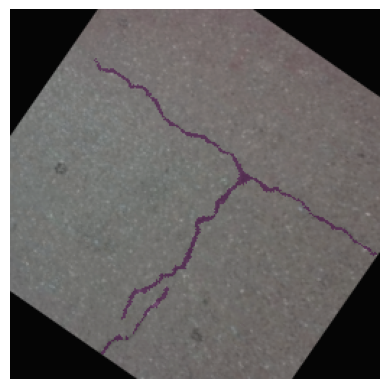

In [2]:
import albumentations as A
import torch
from torch.utils import data

from datasets.segmentation import CrackSeg
from train_utils import segmentation


TRAIN_PERCENTAGE = 0.8
augmentations = [
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=(-60, 60)),
    A.ColorJitter()

]
dataset = CrackSeg("data/crack-segmentation/dataset/image", "data/crack-segmentation/dataset/mask",
                   augmentations)
testset = CrackSeg("data/crack-segmentation/dataset/val_img", "data/crack-segmentation/dataset/val_msk")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
device = torch.device("cuda")
segmentation.show_label(dataset, 1)

In [3]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

In [4]:
from torch.nn import Conv2d, Flatten, Linear, Sequential

from models.tiny_crack_net import TinyCrackNet


NUM_CLASSES = 2
segmenter = TinyCrackNet(NUM_CLASSES)
segmenter.classifier = Sequential(
    segmenter.classifier,
    Flatten(1),
    Linear(NUM_CLASSES * 224 * 224, NUM_CLASSES)
)
segmenter.load_state_dict(torch.load("checkpoints/tcn_crack_class_096_epoch20.pth", weights_only=True))
segmenter.classifier = Conv2d(256, 1, 5, padding=2, bias=False)
segmenter = segmenter.to(device)

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.sgd import SGD

from train_utils.segmentation import JointDiceBCEWithLogitsLoss


criterion = JointDiceBCEWithLogitsLoss(0.8)
optimizer = SGD(segmenter.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience=5)

## Using a 3x3 kernel for classifier

Epoch 50/50: 100%|██████████| 214/214 [01:20<00:00,  2.66it/s]


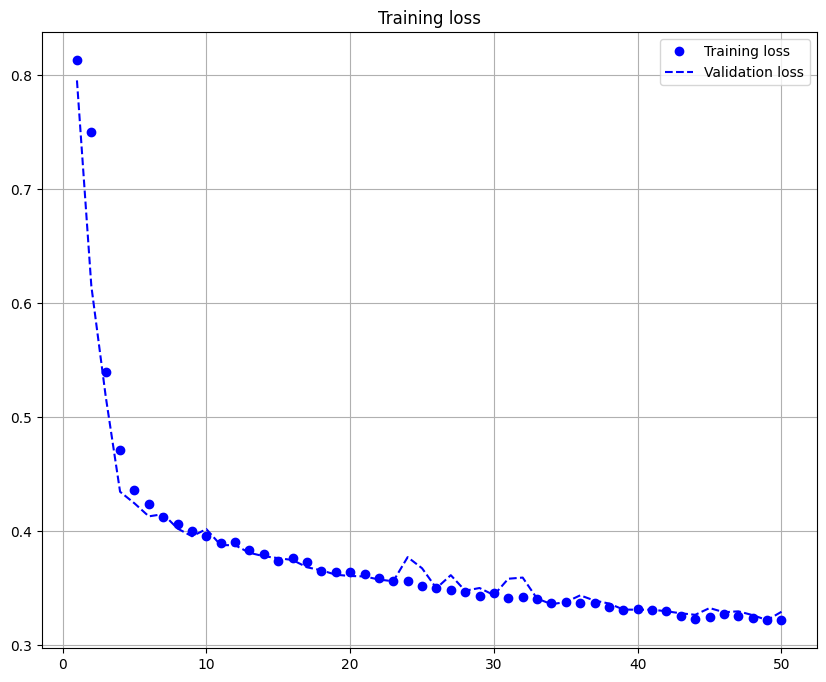

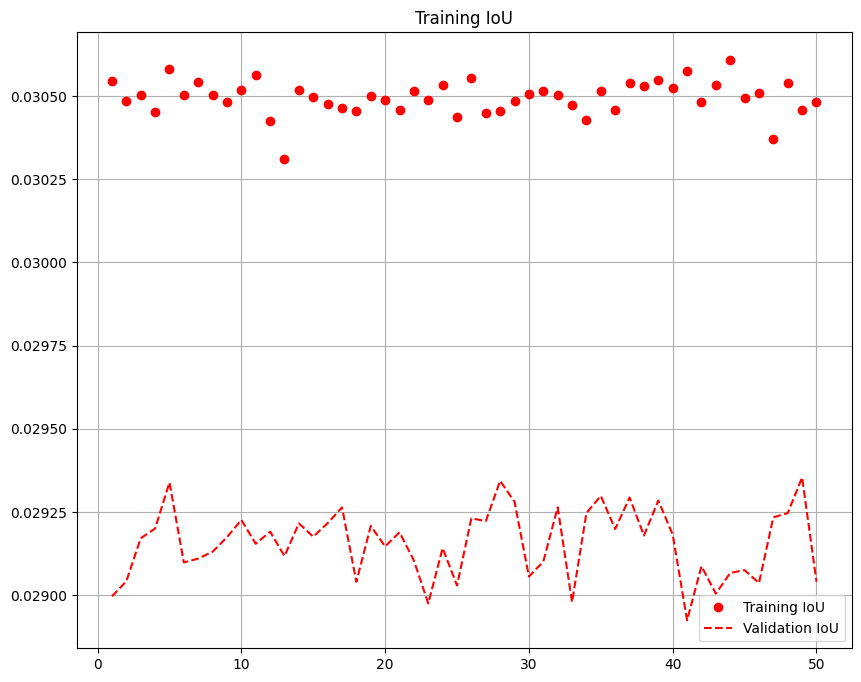

In [5]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 50,
                                                 optimizer, criterion, device, "tcn_cracks_joint_loss_augments_3kernel", scheduler)
loss_hist.plot()
acc_hist.plot()

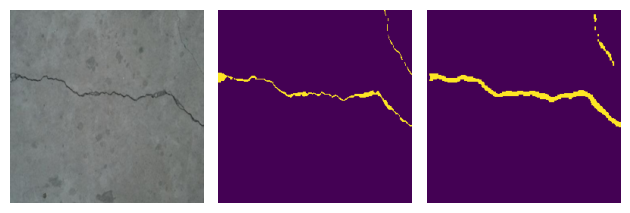

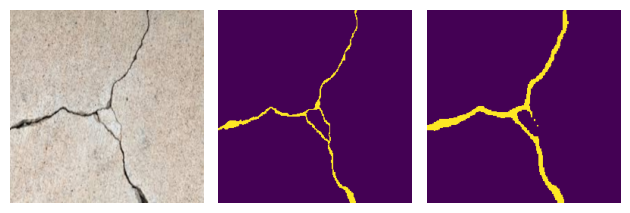

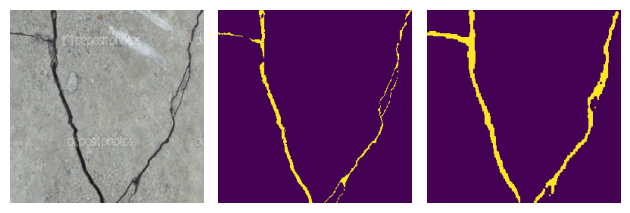

In [6]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_augments_3kernel_0029_epoch49.pth",
                                     weights_only=True))
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)

## Kernel 3x3 bilinear

Epoch 50/50: 100%|██████████| 214/214 [01:22<00:00,  2.58it/s]


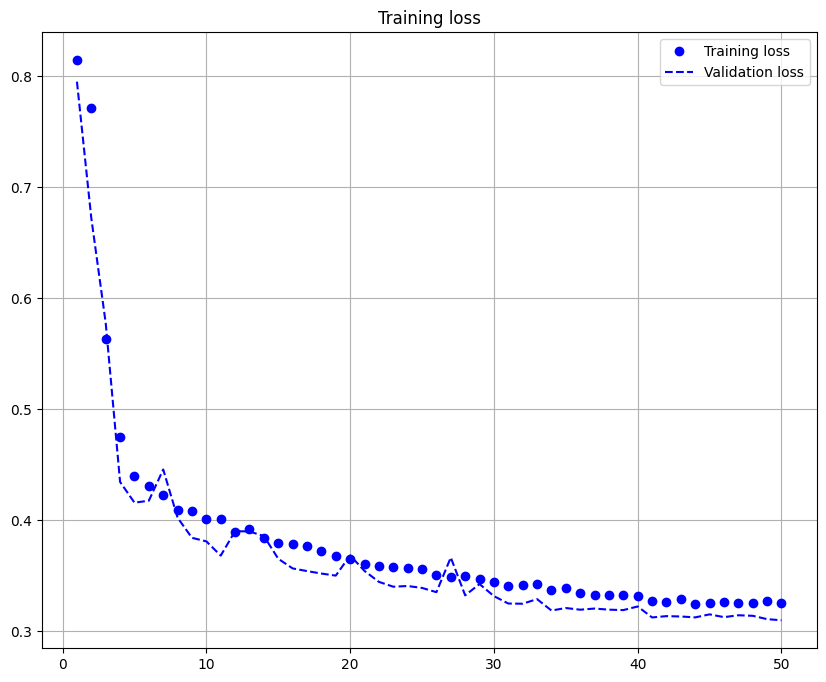

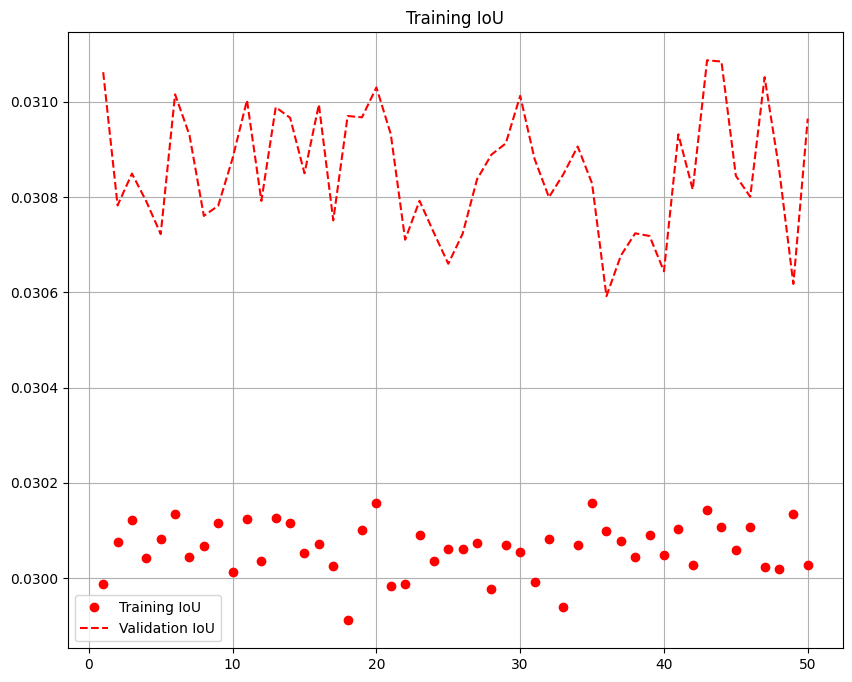

In [5]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 50,
                                               optimizer, criterion, device, "tcn_cracks_joint_loss_augments_3kernel_bilinear", scheduler)
loss_hist.plot()
acc_hist.plot()

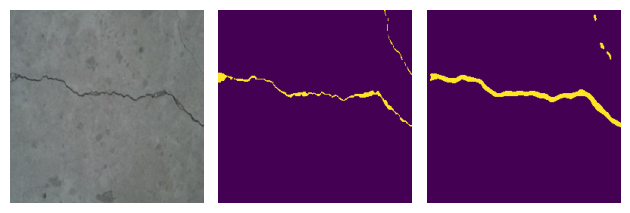

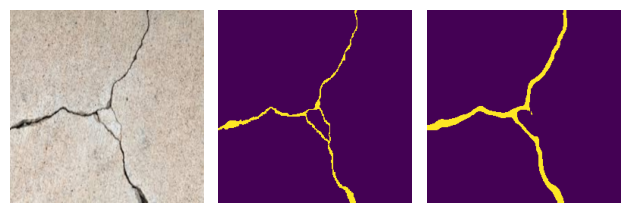

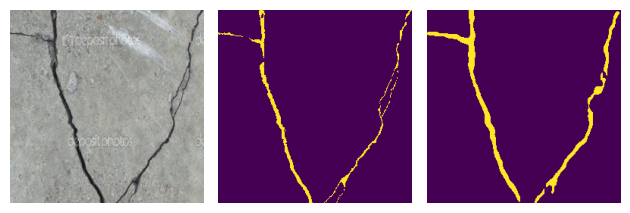

In [7]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_augments_3kernel_bilinear_0031_epoch50.pth",
                                     weights_only=True))
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)

## Kernel size of 5x5

Epoch 50/50: 100%|██████████| 214/214 [01:25<00:00,  2.51it/s]


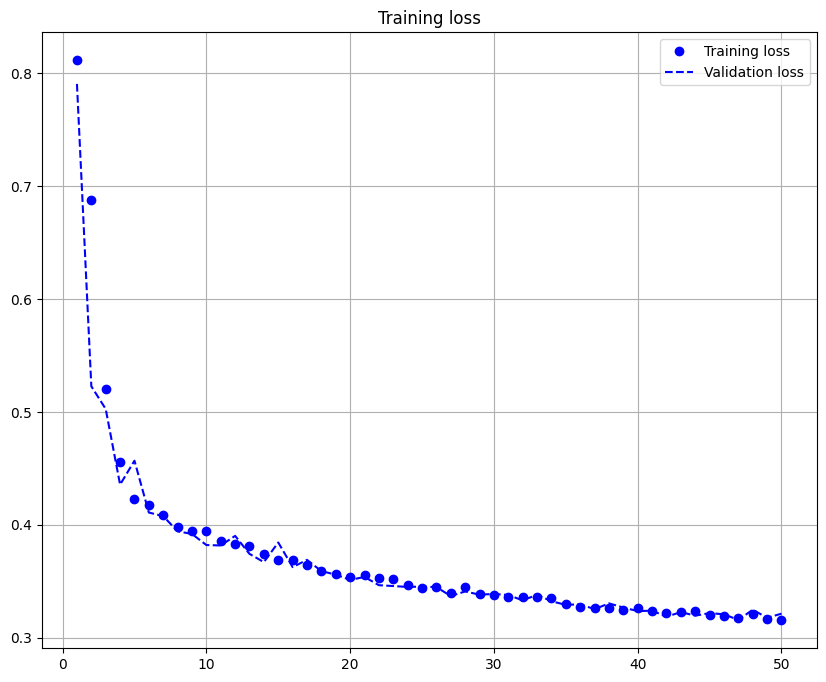

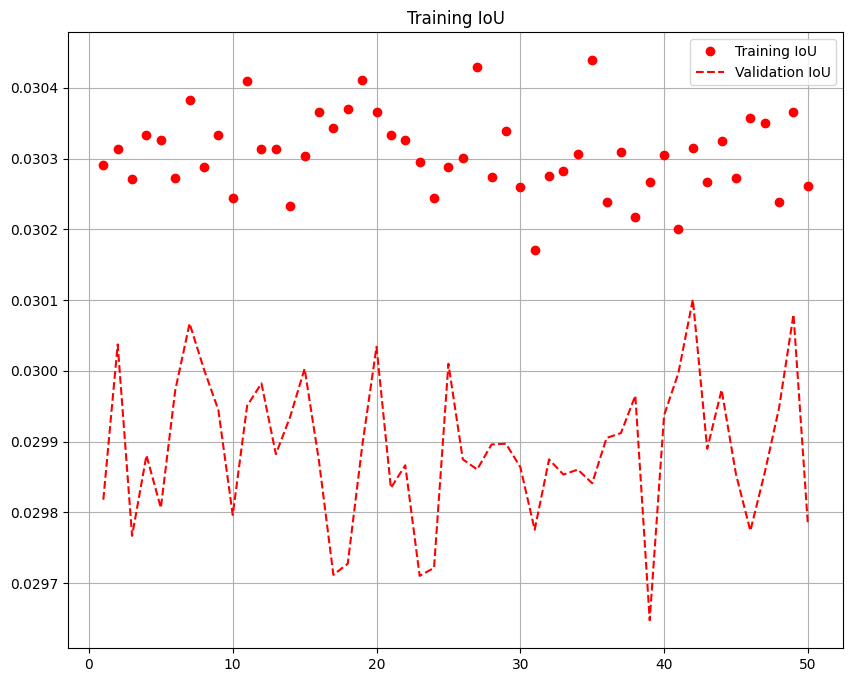

In [5]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 50,
                                                 optimizer, criterion, device, "tcn_cracks_joint_loss_augments_5kernel", scheduler)
loss_hist.plot()
acc_hist.plot()

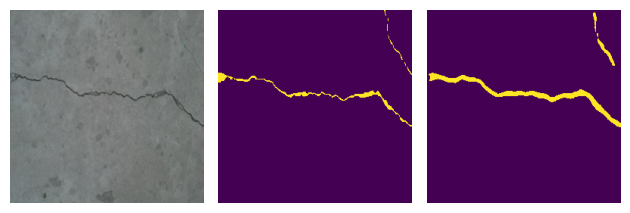

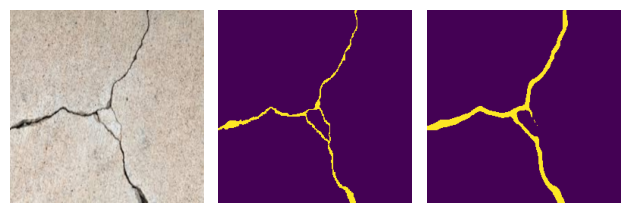

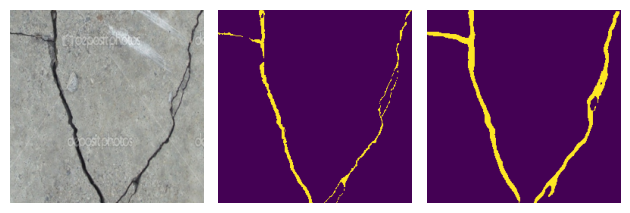

In [ ]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_augments_5kernel_003_epoch50.pth",
                                     weights_only=True))
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)

Epoch 150/150: 100%|██████████| 214/214 [01:25<00:00,  2.51it/s]


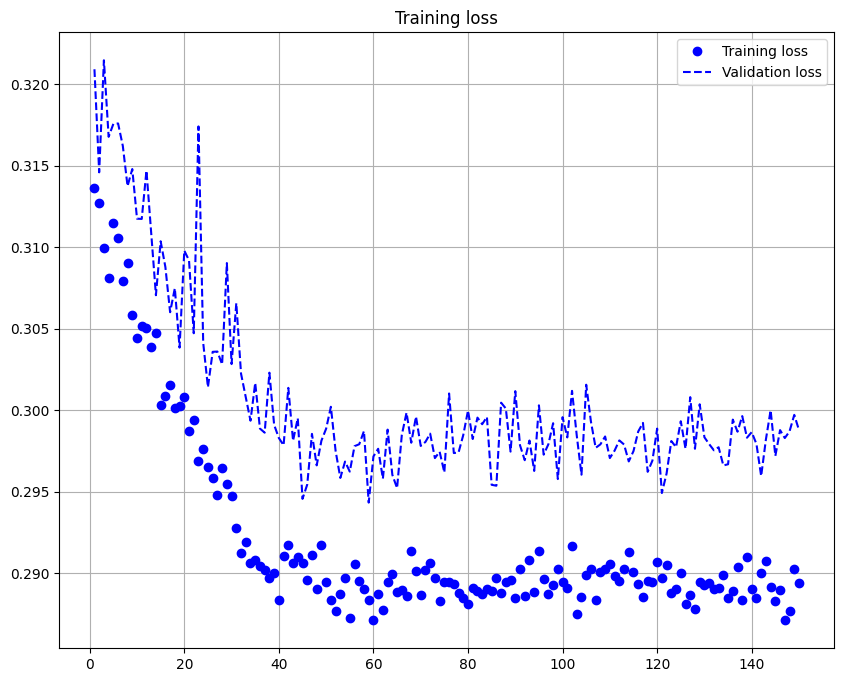

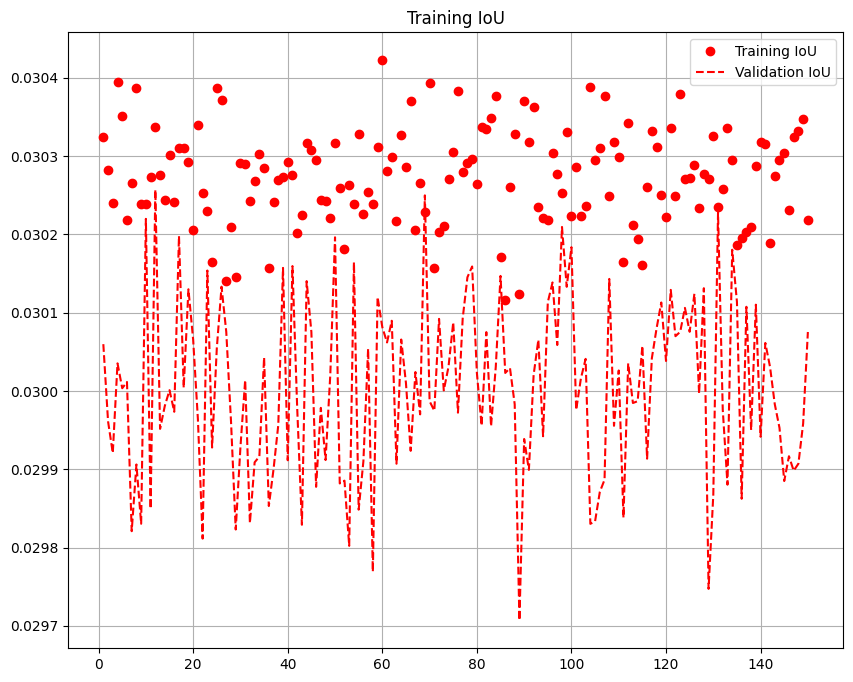

In [10]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 150,
                                                 optimizer, criterion, device, "tcn_cracks_joint_loss_k5", scheduler)
loss_hist.plot()
acc_hist.plot()

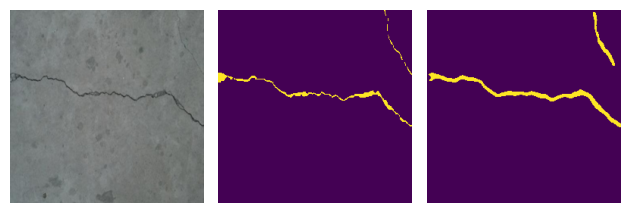

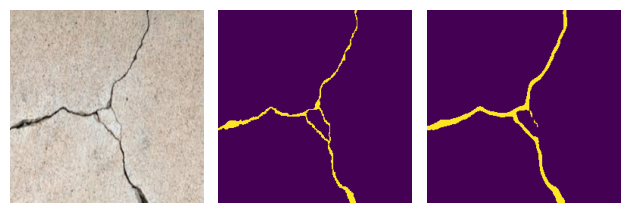

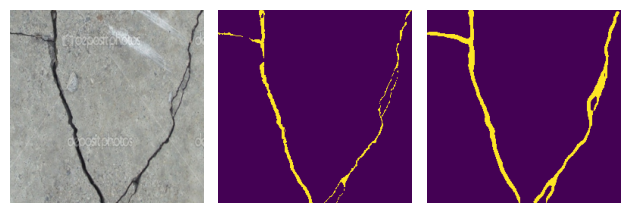

In [11]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_k5_003_epoch150.pth",
                                     weights_only=True))
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)